# Burn scar mapping on Sentinel 2 near real time data

* __Compatability:__ Notebook currently only compatible with DEA Sandbox environment as near real time data is not avaible on the NCI
* **Products used:** 
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),

## Background



This notebook calculates change in Normalised Burn Ratio between a Basline composite image and a post-fire event image in order to find burn scar extent. 
 
The user will need to specify the location of the burn, date of the fire event and select the length of time over wich the composite image will be generated (2, 6 or 12 months). This notebook will automatically generate the composite image over the specified length of time using both Sentinel 2 Near Real Time data and the definative analysis ready product. 

For the post-fire event observation the code will look for the first observation that is at least 60% cloud free. 

## Normalised Burn Ratio

Normalised Burn Ratio (NBR) = (NIR - SWIR) / (NIR + SWIR)

Differenced Normalised Burn Ratio (dNBR) = NBRpre-fire - NBRpost-fire

Relative Difference Normalised Burn Ratio (RdNBR) = dNBR / sqrt(abs(NBRpre-fire))

## Near Real Time vs Analysis Ready Data

Load modules

In [25]:
import sys
import datacube
from datetime import datetime
from datetime import timedelta
import pandas as pd
# from odc.ui import with_ui_cbk

import xarray as xr
import numpy as np

#from datacube_stats.statistics import GeoMedian

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map

In [26]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

## Select Location

the selected latitude and longitude will be displayed on the map below. This map can be used to fin coordinates of other points, scroll and click on any point on the map to display it's latitude and longitude.

In [27]:
#location

#Bogon wilderness
lon=(148.189, 148.417)
lat=(-35.451, -35.6244)

#west of Braidwood
# lon=(149.4642, 149.8247)
# lat=(-35.3101, -35.5724)

#eden, green cape
# lon=(150.2023, 150.2967)
# lat=(-35.6023, -35.7334)


In [28]:
display_map(x=lon, y=lat)

## define fire event date and length of composite image

Delta Normalised Burn Ratio produces the best result when using a post-fire image that was collected before much re-growth has occured. However images collected while the fire is still active can be obsured by smoke. fine tunning of the fire event date may be needed to get the best restlt. 

In [29]:
#Fire event date
fire_date = '2020-01-05'

#length of Geomedian

Geomedian_length = '3 months' # Can be 3, 6 or 12 months



### Automaticaly define date range for pre-fire composite image

In [30]:
#define load for geomedian

if Geomedian_length == '12 months':
    time_step = timedelta(days=365)
if Geomedian_length == '6 months':
    time_step = timedelta(days=182.5)
if Geomedian_length == '3 months':
    time_step = timedelta(days=91)
    
start_date = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-time_step), '%Y-%m-%d')
end_date = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-timedelta(days=1)), '%Y-%m-%d')

change_date_end = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=15)), '%Y-%m-%d')

In [31]:
start_date

'2019-10-06'

### load pre-fire data from Near Real Time Data

In [32]:
#Load all data in basline period avalible from Near Real Time data

NRT_baseline_da = load_ard(dc=dc,
              products=['s2a_nrt_granule', 's2b_nrt_granule'],#,'s2a_ard_granule', 's2b_ard_granule'],
              x=lon,
              y=lat,
              time=(start_date, end_date),
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_2'],
              min_gooddata=0.5,
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              dask_chunks = {'x': 500, 'y': 500},
              group_by='solar_day')

Loading s2a_nrt_granule data
    Filtering to 11 out of 16 observations
    Applying pixel quality mask
Loading s2b_nrt_granule data
    Filtering to 8 out of 15 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 19 observations 


In [33]:
first_NRT_date = (pd.to_datetime((NRT_baseline_da.time[0]).values)).strftime('%Y-%m-%d')

In [34]:
first_NRT_date

'2019-10-20'

### Load pre-fire data from Analysis Ready Data

In [35]:

#Load remaining data in basline period avalible from Analysis Ready Data collection (definative sentinel collection)
ARD_baseline_da = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              x=lon,
              y=lat,
              time=(start_date, first_NRT_date),
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_2'],
              min_gooddata=0.5,
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              dask_chunks = {'x': 500, 'y': 500},
              group_by='solar_day')


Loading s2a_ard_granule data
    Filtering to 1 out of 2 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 2 out of 3 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 3 observations 


In [36]:
### Join all pre-fire data into one dataset

In [37]:
#Concatinate NRT and ARD data together 

combined_basline = xr.concat([ARD_baseline_da,NRT_baseline_da], dim='time').sortby('time')

combined_basline

<xarray.Dataset>
Dimensions:       (time: 22, x: 2294, y: 2174)
Coordinates:
  * y             (y) float64 -3.965e+06 -3.965e+06 ... -3.987e+06 -3.987e+06
  * x             (x) float64 1.461e+06 1.461e+06 ... 1.484e+06 1.484e+06
  * time          (time) datetime64[ns] 2019-10-10T00:11:09.024000 ... 2020-01-03T00:16:36.705676
Data variables:
    nbart_blue    (time, y, x) float32 436.0 396.0 360.0 ... 697.0 705.0 735.0
    nbart_green   (time, y, x) float32 629.0 604.0 602.0 ... 748.0 789.0 776.0
    nbart_red     (time, y, x) float32 662.0 605.0 548.0 ... 725.0 790.0 810.0
    nbart_nir_1   (time, y, x) float32 2726.0 2815.0 2908.0 ... 1968.0 2012.0
    nbart_swir_2  (time, y, x) float32 2255.0 2197.0 2197.0 ... 2240.0 2165.0
Attributes:
    crs:      EPSG:3577

In [38]:
# Generate RGB plots at each timestep
#rgb(baseline_da, index=timesteps)

### generate composite image from pre-fire data

In [39]:

# Compute geomedian using all observations in the dataset
regmedian = combined_basline.median(dim='time')
regmedian 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


<xarray.Dataset>
Dimensions:       (x: 2294, y: 2174)
Coordinates:
  * y             (y) float64 -3.965e+06 -3.965e+06 ... -3.987e+06 -3.987e+06
  * x             (x) float64 1.461e+06 1.461e+06 ... 1.484e+06 1.484e+06
Data variables:
    nbart_blue    (y, x) float32 459.5 457.5 428.0 411.0 ... 316.0 377.0 418.0
    nbart_green   (y, x) float32 652.5 649.0 631.0 619.5 ... 467.0 594.0 608.0
    nbart_red     (y, x) float32 785.0 787.5 783.0 737.0 ... 569.0 703.0 718.0
    nbart_nir_1   (y, x) float32 2606.5 2591.5 2602.5 ... 1490.0 1953.0 2020.0
    nbart_swir_2  (y, x) float32 2202.5 2231.5 2231.5 ... 2065.0 2065.0 2184.0

### Generate Normalised Burn Ration and visualise

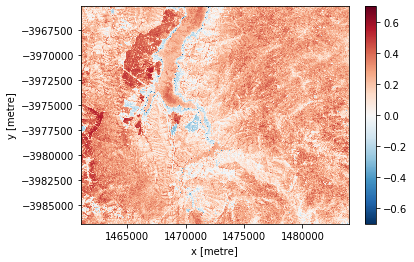

In [40]:
baseline_NBR = (regmedian.nbart_nir_1 - regmedian.nbart_swir_2)/(regmedian.nbart_nir_1 + regmedian.nbart_swir_2)
baseline_NBR.plot()

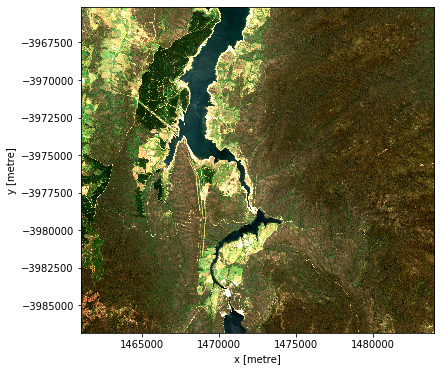

In [41]:
rgb(regmedian, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

### Load post-fire data from Near Real Time data

In [42]:
# Load available data from all three Landsat satellites
Post_da = load_ard(dc=dc,
              products=['s2a_nrt_granule', 's2b_nrt_granule'],
              x=lon,
              y=lat,
              time=(end_date, change_date_end),
              min_gooddata=0.7,
              measurements=['nbart_blue','nbart_green','nbart_red','nbart_nir_1', 'nbart_swir_2'],
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              group_by='solar_day')

# Print output data
print(Post_da)

Loading s2a_nrt_granule data
    Filtering to 1 out of 2 observations
    Applying pixel quality mask
Loading s2b_nrt_granule data
    Filtering to 0 out of 2 observations
Combining and sorting data
Masking out invalid values
    Returning 1 observations 
<xarray.Dataset>
Dimensions:       (time: 1, x: 2294, y: 2174)
Coordinates:
  * y             (y) float64 -3.965e+06 -3.965e+06 ... -3.987e+06 -3.987e+06
  * x             (x) float64 1.461e+06 1.461e+06 ... 1.484e+06 1.484e+06
  * time          (time) datetime64[ns] 2020-01-13T00:16:36.472643
Data variables:
    nbart_blue    (time, y, x) float32 934.0 927.0 925.0 ... 1750.0 1727.0
    nbart_green   (time, y, x) float32 899.0 883.0 881.0 ... 1502.0 1490.0
    nbart_red     (time, y, x) float32 984.0 957.0 944.0 ... 1257.0 1242.0
    nbart_nir_1   (time, y, x) float32 1450.0 1440.0 1357.0 ... 1586.0 1490.0
    nbart_swir_2  (time, y, x) float32 2195.0 2366.0 2366.0 ... 1773.0 1491.0
Attributes:
    crs:      EPSG:3577


### Generate Normalised Burn Ration from post-fire data

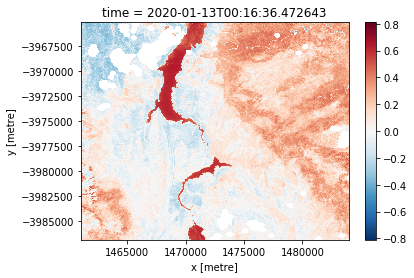

In [43]:
post_NBR = (Post_da.nbart_nir_1 - Post_da.nbart_swir_2)/(Post_da.nbart_nir_1 + Post_da.nbart_swir_2)
post_NBR = post_NBR.isel(time=0)
post_NBR.plot()

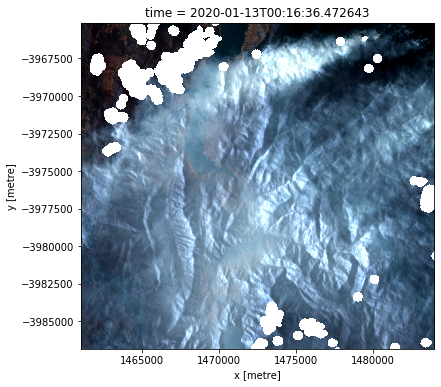

In [44]:
rgb(Post_da, bands=['nbart_red', 'nbart_green', 'nbart_blue'], index=0)

### Caculate Delta Normalised Burn Ratio

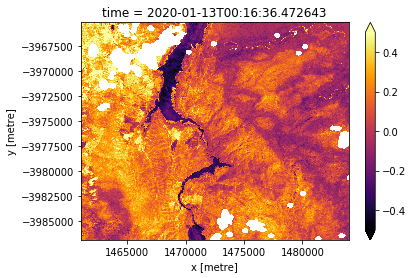

In [45]:
Delta_NBR = baseline_NBR - post_NBR

Delta_NBR.plot(cmap='inferno', vmin=-0.5)

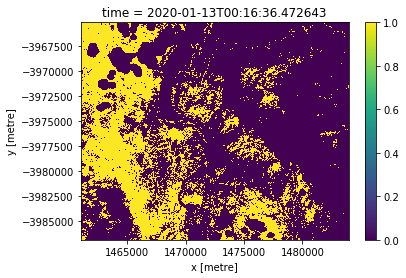

In [46]:
template = xr.full_like(Delta_NBR, 1)

Burned = template.where(Delta_NBR>0.2 ,0)

Burned.plot()

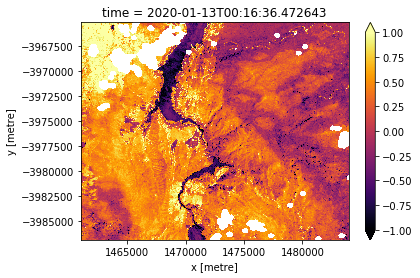

In [47]:
#(RdNBR) = dNBR / sqrt(abs(NBRpre-fire))

R_delta_NBR = Delta_NBR / np.sqrt(np.absolute(baseline_NBR))

R_delta_NBR.plot(cmap='inferno', vmin=-1)

In [48]:
# add in vectorise burn extent? Save to geotiff?
